## Machine Learning
I will now build a number of machine learning models to predict a player's transfer fee from all of the other data we have on the transfer. I will first use classification to approach this problem, by predicting a bucketed range that the transfer fee will fall into. I will then use regression to try to predict the exact transfer fee rather than a bucketed range.

In [1]:
%matplotlib inline
import warnings
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
df = pd.read_csv("cleaned.csv")
df.head()

,Unnamed: 0,Name,Position,Age,Team_from,League_from,Team_to,League_to,Season,Market_value,Transfer_fee
0,0,Luís Figo,Right Midfield,27,FC Barcelona,LaLiga,Real Madrid,LaLiga,2000-2001,NaN,60000000
1,1,Hernán Crespo,Centre-Forward,25,Parma,Serie A,Lazio,Serie A,2000-2001,NaN,56810000
2,2,Marc Overmars,Left Midfield,27,Arsenal,Premier League,FC Barcelona,LaLiga,2000-2001,NaN,40000000
3,3,Gabriel Batistuta,Centre-Forward,31,Fiorentina,Serie A,AS Roma,Serie A,2000-2001,NaN,36150000
4,4,Nicolas Anelka,Centre-Forward,21,Real Madrid,LaLiga,Paris SG,Ligue 1,2000-2001,NaN,34500000


I will first use classification to develop a machine learning model capable of predicting a player's transfer fee based on the other attributes (besides name for obvious reasons and market value due to presence of a lot of Nan's).

In [2]:
class_df = df.drop(columns=["Unnamed: 0","Name", "Market_value"])
class_df.head()

,Position,Age,Team_from,League_from,Team_to,League_to,Season,Transfer_fee
0,Right Midfield,27,FC Barcelona,LaLiga,Real Madrid,LaLiga,2000-2001,60000000
1,Centre-Forward,25,Parma,Serie A,Lazio,Serie A,2000-2001,56810000
2,Left Midfield,27,Arsenal,Premier League,FC Barcelona,LaLiga,2000-2001,40000000
3,Centre-Forward,31,Fiorentina,Serie A,AS Roma,Serie A,2000-2001,36150000
4,Centre-Forward,21,Real Madrid,LaLiga,Paris SG,Ligue 1,2000-2001,34500000


Now we will add a column showing the bucket a transfer fee falls into. A classification machine learning algorithm cannot predict discrete values and is suited to predicting categorical values. Transfer_fee is obviously a discrete value, so we will use buckets to make this into a categorical value.

In [3]:
class_df["Transfer_fee"].describe()

count    4.700000e+03
mean     9.447586e+06
std      1.043772e+07
min      8.250000e+05
25%      4.000000e+06
50%      6.500000e+06
75%      1.082000e+07
max      2.220000e+08
Name: Transfer_fee, dtype: float64

In [4]:
#params: function to create buckets for the transfer fee where data is the dataframe, and n is the number of buckets
#returns: a new dataframe where "bucket" exists as a column and the "Transfer_fee" column is dropped
def create_buckets(data, n):
    out_df = data.copy()
    out_df["bucket"] = pd.qcut(out_df["Transfer_fee"], q=n)
    out_df = out_df.drop(columns=["Transfer_fee"])
    return out_df

#### Data Encoding

A key problem with this dataset at the moment is that I have lots of categorical variables, but computers only see numbers. Thus, I need to encode my categorical variables to be numerical values. There are two options for each column, label encoding, in which I just assign each unique value in a column a unique number. This works well for ordinal categorical variables such as season because it the assignment of a unique number forces the algorithm to interpret unique relationships in the same order as what you would expect. (i.e. first season gets assigned 0 and second season gets assigned 1). However, this would not work well for something like Position because there is no ordinal relationship there. For columns where there is not an ordinal relationship, I will use one-hot encoding, in which I essentially create a dummy variable for each unique value in the column.

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import patsy as pts

bucketed_df = create_buckets(class_df, 10)

#Label Encoding on Season and Bucket columns
season_le = LabelEncoder()
bucketed_df['Season'] = season_le.fit_transform(bucketed_df['Season'])
target_le = LabelEncoder().fit(bucketed_df['bucket'])
bucketed_df['bucket'] = target_le.transform(bucketed_df['bucket'])

#Performing one-hot encoding on Position, Team_from, League_from, Team_to, and League_to

Y, X = pts.dmatrices('bucket ~ C(Position) + Age + C(Team_from) + C(League_from) + C(Team_to) + C(League_to) + Season',
                    data = bucketed_df,
                    return_type='dataframe')
None

In [8]:
np_Y = Y['bucket'].to_numpy()

In the code cell below, I scale the data columns to have a mean of 0 and standard deviation of 1. I found that this led to a general improvement in the models performance, which makes sense because many of the columns of the input do not follow a normal distribution and some of them use different scales.

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X),columns = X.columns)
X.head()

,Intercept,C(Position)[T.Central Midfield],C(Position)[T.Centre-Back],C(Position)[T.Centre-Forward],C(Position)[T.Defensive Midfield],C(Position)[T.Goalkeeper],C(Position)[T.Left Midfield],C(Position)[T.Left-Back],C(Position)[T.Right Midfield],C(Position)[T.Right-Back],...,C(League_to)[T.Stars League],C(League_to)[T.Super League],C(League_to)[T.SuperLiga],C(League_to)[T.Superligaen],C(League_to)[T.Série A],C(League_to)[T.Süper Lig],C(League_to)[T.Torneo Final],C(League_to)[T.UAE Gulf League],Age,Season
0,0.0,-0.340381,-0.423933,-0.635141,-0.309559,-0.199557,-0.285402,-0.224231,3.430997,-0.200133,...,-0.06371,-0.163246,-0.014588,-0.025273,-0.102642,-0.177145,-0.046176,-0.065372,0.823806,-1.645154
1,0.0,-0.340381,-0.423933,1.574454,-0.309559,-0.199557,-0.285402,-0.224231,-0.291460,-0.200133,...,-0.06371,-0.163246,-0.014588,-0.025273,-0.102642,-0.177145,-0.046176,-0.065372,0.204700,-1.645154
2,0.0,-0.340381,-0.423933,-0.635141,-0.309559,-0.199557,3.503832,-0.224231,-0.291460,-0.200133,...,-0.06371,-0.163246,-0.014588,-0.025273,-0.102642,-0.177145,-0.046176,-0.065372,0.823806,-1.645154
3,0.0,-0.340381,-0.423933,1.574454,-0.309559,-0.199557,-0.285402,-0.224231,-0.291460,-0.200133,...,-0.06371,-0.163246,-0.014588,-0.025273,-0.102642,-0.177145,-0.046176,-0.065372,2.062018,-1.645154
4,0.0,-0.340381,-0.423933,1.574454,-0.309559,-0.199557,-0.285402,-0.224231,-0.291460,-0.200133,...,-0.06371,-0.163246,-0.014588,-0.025273,-0.102642,-0.177145,-0.046176,-0.065372,-1.033512,-1.645154


#### Custom Classification Report


I want to include cross validation in my method comparison, so I will write a quick function for a custom classification report using nested cross validation. This means that I will perform cross validation on 5 different folds of data (outer folds), and then I will perform a grid search on inner folds for each of the 5 outer folds in order to find optimal hyperparameters for each model.

In [10]:
from sklearn.metrics import classification_report, accuracy_score, make_scorer

originalclass = []
predictedclass = []

def custom_classification_scoring(y_true, y_pred, is_training=True):
    originalclass.extend(y_true)
    predictedclass.extend(y_pred)
    '''
    print("originalclass")
    print(originalclass)
    print("predictedclass")
    print(predictedclass)
    '''
    # Custom Accuracy function to measure the distance of the predicted value from the true value rather than a simple
    # accuracy score that only determines if the datapoint was correctly classified or not
    diff = np.abs(y_true - y_pred) / 10.0
    score = (1.0 - diff)
    ret_val = score.mean()
    if is_training:
        print("Mean Relative Accuracy of this outer fold is: ")
        print(ret_val)
    return ret_val

def run_model(model, parameters, X, Y):
    clf = GridSearchCV(estimator=model, param_grid=parameters, n_jobs = -1)
    clf.fit(X, Y)
    nested_score = cross_val_score(clf, X=X, y=Y, scoring=make_scorer(custom_classification_scoring), verbose=3).mean()
    return classification_report(originalclass, predictedclass, zero_division=0), clf.best_params_, nested_score




In [11]:
X_train, X_test, y_train, y_test = train_test_split( X, np_Y, test_size=0.2, random_state=23)

Now that I have split my data into a training and testing set and written methods for cross validation, grid searching, and custom scoring, I am ready to compare different models.

## Classification Model Comparison

#### KNN

In [12]:
from sklearn.neighbors import KNeighborsClassifier

originalclass = []
predictedclass = []

params = {
    'n_neighbors': np.arange(3, 16),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean']
}

knn_report, knn_best_params, knn_nested_score = run_model(KNeighborsClassifier(n_jobs = -1), params, X_train, y_train)
print(knn_best_params)
print(knn_report)
print("Mean Relative Accuracy of all outer folds is: ")
print(knn_nested_score)

test_model = KNeighborsClassifier(n_neighbors=knn_best_params['n_neighbors'],
                                  weights=knn_best_params['weights'],
                                  metric=knn_best_params['metric'],
                                  n_jobs = -1).fit(X_train, y_train)
print("The accuracy on the test dataset is: ")
print(custom_classification_scoring(y_test, test_model.predict(X_test), is_training=False))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean Relative Accuracy of this outer fold is: 
0.7351063829787233
[CV] END ................................ score: (test=0.735) total time=  11.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.3s remaining:    0.0s


Mean Relative Accuracy of this outer fold is: 
0.7398936170212768
[CV] END ................................ score: (test=0.740) total time=  11.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   22.3s remaining:    0.0s


Mean Relative Accuracy of this outer fold is: 
0.7208776595744681
[CV] END ................................ score: (test=0.721) total time=  11.0s
Mean Relative Accuracy of this outer fold is: 
0.7232712765957447
[CV] END ................................ score: (test=0.723) total time=  10.8s
Mean Relative Accuracy of this outer fold is: 
0.7363031914893617
[CV] END ................................ score: (test=0.736) total time=  11.2s
{'metric': 'euclidean', 'n_neighbors': 8, 'weights': 'distance'}
              precision    recall  f1-score   support

         0.0       0.34      0.19      0.24       403
         1.0       0.16      0.11      0.13       358
         2.0       0.15      0.12      0.14       438
         3.0       0.09      0.07      0.08       305
         4.0       0.13      0.14      0.13       394
         5.0       0.14      0.13      0.14       464
         6.0       0.08      0.06      0.07       254
         7.0       0.12      0.12      0.12       392
       

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   55.3s finished


0.7243617021276597


We can see the results form KNN Classification above. We see the 'Mean Relative Accuracy' for each outer fold, the output of the classification report (which uses exact accuracy rather than the 'Mean Relative Accuracy'), and then we can see the average MRA on all folds and on the test set after being trained on the entire training set. We will now continue to repeat this process with various other classification methods.

#### Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier

originalclass = []
predictedclass = []

#I could do more hyperparamter tuning than this, but it honestly just takes way too long to run on my computer
params = {
    'bootstrap': [True],
    'max_depth': [10, 50],
    'max_features': ['auto', 'sqrt'],
    'n_estimators': [200, 1000]
}

rf_report, rf_best_params, rf_nested_score = run_model(RandomForestClassifier(n_jobs = -1), params, X_train, y_train)
print(rf_best_params)
print(rf_report)
print("Mean Relative Accuracy of all outer folds is: ")
print(rf_nested_score)

test_model = RandomForestClassifier(bootstrap=rf_best_params['bootstrap'],
                                    max_depth=rf_best_params['max_depth'],
                                    max_features=rf_best_params['max_features'],
                                    n_estimators=rf_best_params['n_estimators'],
                                    n_jobs = -1).fit(X_train, y_train)
print("The accuracy on the test dataset is: ")
print(custom_classification_scoring(y_test, test_model.predict(X_test), is_training=False))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean Relative Accuracy of this outer fold is: 
0.8049202127659574
[CV] END ................................ score: (test=0.805) total time= 1.8min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s


Mean Relative Accuracy of this outer fold is: 
0.8021276595744682
[CV] END ................................ score: (test=0.802) total time= 1.9min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.8min remaining:    0.0s


Mean Relative Accuracy of this outer fold is: 
0.8091755319148937
[CV] END ................................ score: (test=0.809) total time= 2.1min
Mean Relative Accuracy of this outer fold is: 
0.8021276595744682
[CV] END ................................ score: (test=0.802) total time= 1.9min
Mean Relative Accuracy of this outer fold is: 
0.8190159574468084
[CV] END ................................ score: (test=0.819) total time= 2.0min
{'bootstrap': True, 'max_depth': 50, 'max_features': 'sqrt', 'n_estimators': 200}
              precision    recall  f1-score   support

         0.0       0.44      0.81      0.57       403
         1.0       0.27      0.16      0.20       358
         2.0       0.22      0.25      0.24       438
         3.0       0.13      0.06      0.08       305
         4.0       0.13      0.08      0.10       394
         5.0       0.19      0.25      0.22       464
         6.0       0.12      0.04      0.05       254
         7.0       0.20      0.19      0.19 

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.9min finished


The accuracy on the test dataset is: 
0.8089361702127661


#### AdaBoost

In [14]:
from sklearn.ensemble import AdaBoostClassifier

originalclass = []
predictedclass = []

#I could do more hyperparamter tuning than this, but it honestly just takes way too long to run on my computer
params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5]
}

ada_report, ada_best_params, ada_nested_score = run_model(AdaBoostClassifier(), params, X_train, y_train)
print(ada_best_params)
print(ada_report)
print("Mean Relative Accuracy of all outer folds is: ")
print(ada_nested_score)

test_model = AdaBoostClassifier(learning_rate=ada_best_params['learning_rate'],
                                n_estimators=ada_best_params['n_estimators']).fit(X_train, y_train)
print("The accuracy on the test dataset is: ")
print(custom_classification_scoring(y_test, test_model.predict(X_test), is_training=False))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean Relative Accuracy of this outer fold is: 
0.7542553191489362
[CV] END ................................ score: (test=0.754) total time= 2.1min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min remaining:    0.0s


Mean Relative Accuracy of this outer fold is: 
0.7631648936170214
[CV] END ................................ score: (test=0.763) total time= 2.1min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.2min remaining:    0.0s


Mean Relative Accuracy of this outer fold is: 
0.7515957446808511
[CV] END ................................ score: (test=0.752) total time= 2.2min
Mean Relative Accuracy of this outer fold is: 
0.7640957446808511
[CV] END ................................ score: (test=0.764) total time= 2.1min
Mean Relative Accuracy of this outer fold is: 
0.7664893617021278
[CV] END ................................ score: (test=0.766) total time= 2.1min
{'learning_rate': 0.01, 'n_estimators': 200}
              precision    recall  f1-score   support

         0.0       0.35      0.98      0.51       403
         1.0       0.32      0.19      0.24       358
         2.0       0.20      0.44      0.27       438
         3.0       0.00      0.00      0.00       305
         4.0       0.00      0.00      0.00       394
         5.0       0.17      0.49      0.25       464
         6.0       0.00      0.00      0.00       254
         7.0       0.09      0.00      0.00       392
         8.0       0.18    

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 10.6min finished


The accuracy on the test dataset is: 
0.7672340425531915


#### Support Vector Machine

In [15]:
from sklearn.svm import SVC

originalclass = []
predictedclass = []

params = {
    'C': [0.1,0.5,1],
    'gamma': [0.1,0.5,1.0],
    'kernel': ['rbf','linear']
}

svm_report, svm_best_params, svm_nested_score = run_model(SVC(), params, X_train, y_train)
print(svm_best_params)
print(svm_report)
print("Mean Relative Accuracy of all outer folds is: ")
print(svm_nested_score)

test_model = SVC(C=svm_best_params['C'],
                 gamma=svm_best_params['gamma'],
                 kernel=svm_best_params['kernel']).fit(X_train, y_train)
print("The accuracy on the test dataset is: ")
print(custom_classification_scoring(y_test, test_model.predict(X_test), is_training=False))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean Relative Accuracy of this outer fold is: 
0.7868351063829788
[CV] END ................................ score: (test=0.787) total time= 4.8min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.8min remaining:    0.0s


Mean Relative Accuracy of this outer fold is: 
0.7848404255319149
[CV] END ................................ score: (test=0.785) total time= 4.7min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  9.5min remaining:    0.0s


Mean Relative Accuracy of this outer fold is: 
0.7908244680851064
[CV] END ................................ score: (test=0.791) total time= 5.1min
Mean Relative Accuracy of this outer fold is: 
0.785372340425532
[CV] END ................................ score: (test=0.785) total time= 4.6min
Mean Relative Accuracy of this outer fold is: 
0.7970744680851064
[CV] END ................................ score: (test=0.797) total time= 4.6min
{'C': 0.5, 'gamma': 0.1, 'kernel': 'linear'}
              precision    recall  f1-score   support

         0.0       0.43      0.36      0.39       403
         1.0       0.19      0.21      0.20       358
         2.0       0.16      0.17      0.17       438
         3.0       0.12      0.10      0.11       305
         4.0       0.12      0.13      0.13       394
         5.0       0.18      0.18      0.18       464
         6.0       0.09      0.08      0.08       254
         7.0       0.15      0.15      0.15       392
         8.0       0.20     

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 23.8min finished


The accuracy on the test dataset is: 
0.7888297872340425


#### Gaussian Naive Bayes

In [16]:
from sklearn.naive_bayes import GaussianNB
originalclass = []
predictedclass = []

params = {'var_smoothing': np.logspace(0,-9, num=10)}

gnb_report, gnb_best_params, gnb_nested_score = run_model(GaussianNB(), params, X_train, y_train)
print(gnb_best_params)
print(gnb_report)
print("Mean Relative Accuracy of all outer folds is: ")
print(gnb_nested_score)

test_model = GaussianNB(var_smoothing=gnb_best_params['var_smoothing']).fit(X_train, y_train)
print("The accuracy on the test dataset is: ")
print(custom_classification_scoring(y_test, test_model.predict(X_test), is_training=False))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean Relative Accuracy of this outer fold is: 
0.7308510638297873
[CV] END ................................ score: (test=0.731) total time=   2.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


Mean Relative Accuracy of this outer fold is: 
0.7308510638297872
[CV] END ................................ score: (test=0.731) total time=   2.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s


Mean Relative Accuracy of this outer fold is: 
0.7417553191489361
[CV] END ................................ score: (test=0.742) total time=   2.1s
Mean Relative Accuracy of this outer fold is: 
0.730186170212766
[CV] END ................................ score: (test=0.730) total time=   2.5s
Mean Relative Accuracy of this outer fold is: 
0.7400265957446809
[CV] END ................................ score: (test=0.740) total time=   2.1s
{'var_smoothing': 1e-05}
              precision    recall  f1-score   support

         0.0       0.47      0.15      0.23       403
         1.0       0.21      0.11      0.15       358
         2.0       0.23      0.07      0.11       438
         3.0       0.15      0.11      0.13       305
         4.0       0.16      0.09      0.12       394
         5.0       0.16      0.07      0.09       464
         6.0       0.10      0.20      0.13       254
         7.0       0.12      0.09      0.10       392
         8.0       0.13      0.20      0.16     

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.6s finished


#### Neural Network

In [17]:
from sklearn.neural_network import MLPClassifier
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
originalclass = []
predictedclass = []

params = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

mlp_report, mlp_best_params, mlp_nested_score = run_model(MLPClassifier(verbose=False), params, X_train, y_train)
print(mlp_best_params)
print(mlp_report)
print("Mean Relative Accuracy of all outer folds is: ")
print(mlp_nested_score)

test_model = MLPClassifier(verbose=False,
                           learning_rate=mlp_best_params['learning_rate'],
                           activation=mlp_best_params['activation'],
                           hidden_layer_sizes=mlp_best_params['hidden_layer_sizes'],
                           solver=mlp_best_params['solver'],
                           alpha=mlp_best_params['alpha']).fit(X_train, y_train)
print("The accuracy on the test dataset is: ")
print(custom_classification_scoring(y_test, test_model.predict(X_test), is_training=False))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean Relative Accuracy of this outer fold is: 
0.7867021276595745
[CV] END ................................ score: (test=0.787) total time= 6.1min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.1min remaining:    0.0s


Mean Relative Accuracy of this outer fold is: 
0.7751329787234044
[CV] END ................................ score: (test=0.775) total time= 6.4min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 12.5min remaining:    0.0s


Mean Relative Accuracy of this outer fold is: 
0.788031914893617
[CV] END ................................ score: (test=0.788) total time= 7.3min
Mean Relative Accuracy of this outer fold is: 
0.7844414893617021
[CV] END ................................ score: (test=0.784) total time= 7.2min
Mean Relative Accuracy of this outer fold is: 
0.798404255319149
[CV] END ................................ score: (test=0.798) total time= 6.1min
{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'adaptive', 'solver': 'sgd'}
              precision    recall  f1-score   support

         0.0       0.35      0.38      0.36       403
         1.0       0.14      0.15      0.15       358
         2.0       0.18      0.17      0.18       438
         3.0       0.09      0.08      0.08       305
         4.0       0.14      0.12      0.13       394
         5.0       0.15      0.16      0.15       464
         6.0       0.09      0.05      0.07       254
      

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 33.2min finished


The accuracy on the test dataset is: 
0.7930851063829787


#### RF Classification Visualization

Based on both the Mean Relative Accuracy on all outer folds on the training dataset and then also on the testing dataset, the Random Forest Classifier performs the best. Here's a Graph of the Random Forest Classifier's predicted output vs actual value on the test set when trained on the entire dataset.

In [18]:
test_model = RandomForestClassifier(bootstrap=rf_best_params['bootstrap'],
                                    max_depth=rf_best_params['max_depth'],
                                    max_features=rf_best_params['max_features'],
                                    n_estimators=rf_best_params['n_estimators'],
                                    n_jobs = -1).fit(X_train, y_train)
plotting_data = pd.DataFrame({'true_vals': y_test, 'predicted_vals': test_model.predict(X_test)})

In [19]:
counts = plotting_data.value_counts()
counts_dic = counts.to_dict()
plotting_data['count'] = np.zeros((plotting_data.shape[0],))
for index, row in plotting_data.iterrows():
    row['count'] = counts_dic[(row['true_vals'], row['predicted_vals'])]

In [20]:
plotting_data['count'].value_counts()

81.0    81
16.0    80
7.0     63
60.0    60
17.0    51
12.0    48
48.0    48
14.0    42
21.0    42
13.0    39
6.0     36
3.0     36
11.0    33
32.0    32
8.0     32
15.0    30
26.0    26
2.0     26
23.0    23
10.0    20
5.0     20
19.0    19
18.0    18
9.0     18
4.0     12
1.0      5
Name: count, dtype: int64

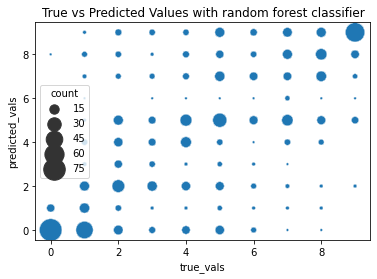

In [21]:
sns.scatterplot(x='true_vals', y='predicted_vals',
             data = plotting_data, size='count', sizes=(0, 500)
             ).set_title('True vs Predicted Values with random forest classifier')
None

Most predictions do seem to be pretty close to their true value. Obviously, some are very far off, but the accuracy achieved is surprisingly good for how little data we have.

## Regression Modeling

Now I will try to solve the same problem with a slightly different approach. I will treat the problem as regression rather than classification, still trying to predict a player's transfer fee. Note, I will need to use slightly different metrics to evaluate these models because the 'Mean Relative Accuracy' from the classification problems is no longer applicable due to this being a regression problem rather than classification into 10 different categories. The scoring that I have chosen to use is the classic R Squared metric for regression. I have also included information about the explained variance in each outer fold. Other than that, the cross validation process is very similar to what it was when performing classification.

In [22]:
reg_season_le = LabelEncoder()
class_df['Season'] = reg_season_le.fit_transform(class_df['Season'])

class_df.sort_values('Season')

,Position,Age,Team_from,League_from,Team_to,League_to,Season,Transfer_fee
0,Right Midfield,27,FC Barcelona,LaLiga,Real Madrid,LaLiga,0,60000000
157,Left Midfield,23,Atlético Madrid,LaLiga2,Real Madrid,LaLiga,0,3500000
158,Defensive Midfield,24,Hamburger SV,1.Bundesliga,Everton,Premier League,0,3500000
159,Centre-Forward,23,Busan IPark,"Korea, South",Perugia,Serie A,0,3500000
160,Attacking Midfield,27,Sevilla FC,LaLiga2,AEK Athens,Super League,0,3500000
...,...,...,...,...,...,...,...,...
4541,Left Midfield,23,Norwich,Championship,Cardiff,Premier League,18,11400000
4542,Attacking Midfield,25,Bristol City,Championship,Cardiff,Premier League,18,11350000
4543,Attacking Midfield,20,Sheffield Utd.,Championship,Bournemouth,Premier League,18,11300000
4545,Right Midfield,26,Huddersfield,Premier League,Stoke City,Championship,18,11200000


In [23]:
#Performing one-hot encoding on Position, Team_from, League_from, Team_to, and League_to

Y, X = pts.dmatrices('Transfer_fee ~ C(Position) + Age + C(Team_from) + C(League_from) + C(Team_to) + C(League_to) + Season',
                    data = class_df,
                    return_type='dataframe')

np_Y = Y['Transfer_fee'].to_numpy()
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X),columns = X.columns)
X.head()

,Intercept,C(Position)[T.Central Midfield],C(Position)[T.Centre-Back],C(Position)[T.Centre-Forward],C(Position)[T.Defensive Midfield],C(Position)[T.Goalkeeper],C(Position)[T.Left Midfield],C(Position)[T.Left-Back],C(Position)[T.Right Midfield],C(Position)[T.Right-Back],...,C(League_to)[T.Stars League],C(League_to)[T.Super League],C(League_to)[T.SuperLiga],C(League_to)[T.Superligaen],C(League_to)[T.Série A],C(League_to)[T.Süper Lig],C(League_to)[T.Torneo Final],C(League_to)[T.UAE Gulf League],Age,Season
0,0.0,-0.340381,-0.423933,-0.635141,-0.309559,-0.199557,-0.285402,-0.224231,3.430997,-0.200133,...,-0.06371,-0.163246,-0.014588,-0.025273,-0.102642,-0.177145,-0.046176,-0.065372,0.823806,-1.645154
1,0.0,-0.340381,-0.423933,1.574454,-0.309559,-0.199557,-0.285402,-0.224231,-0.291460,-0.200133,...,-0.06371,-0.163246,-0.014588,-0.025273,-0.102642,-0.177145,-0.046176,-0.065372,0.204700,-1.645154
2,0.0,-0.340381,-0.423933,-0.635141,-0.309559,-0.199557,3.503832,-0.224231,-0.291460,-0.200133,...,-0.06371,-0.163246,-0.014588,-0.025273,-0.102642,-0.177145,-0.046176,-0.065372,0.823806,-1.645154
3,0.0,-0.340381,-0.423933,1.574454,-0.309559,-0.199557,-0.285402,-0.224231,-0.291460,-0.200133,...,-0.06371,-0.163246,-0.014588,-0.025273,-0.102642,-0.177145,-0.046176,-0.065372,2.062018,-1.645154
4,0.0,-0.340381,-0.423933,1.574454,-0.309559,-0.199557,-0.285402,-0.224231,-0.291460,-0.200133,...,-0.06371,-0.163246,-0.014588,-0.025273,-0.102642,-0.177145,-0.046176,-0.065372,-1.033512,-1.645154


In [24]:
X_train, X_test, y_train, y_test = train_test_split( X, np_Y, test_size=0.2, random_state=23)

In [25]:
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
def reg_scorer(y_true, y_pred, is_training=True):
    originalclass.extend(y_true)
    predictedclass.extend(y_pred)
    '''
    print("originalclass")
    print(originalclass)
    print("predictedclass")
    print(predictedclass)
    '''
    # Custom Accuracy function to measure the distance of the predicted value from the true value rather than a simple
    # accuracy score that only determines if the datapoint was correctly classified or not
    exp_var = explained_variance_score(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    if is_training:
        print("Explained Variance of this outer fold is: ")
        print(exp_var)
        print("The R2 of this outer fold is: ")
        print(r2)
    return r2

def run_reg_model(model, parameters, X, y):
    clf = GridSearchCV(estimator=model, param_grid=parameters, n_jobs = -1)
    clf.fit(X, y)
    nested_r2 = cross_val_score(model, X=X, y=y, scoring=make_scorer(reg_scorer), verbose=3).mean()
    return clf.best_params_, nested_r2

## Model Selection


Now I have prepared my training and testing datasets similarly to before and written a custom regression scoring function. Let's compare the various regression models.

#### KNN Regressor

In [26]:
from sklearn.neighbors import KNeighborsRegressor
params = {
    'n_neighbors': np.arange(3, 16),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean']
}

originalclass = []
predictedclass = []

rknn_best_params, rknn_nested_score = run_reg_model(KNeighborsRegressor(n_jobs = -1), params, X_train, y_train)
print("The best parameters are: ")
print(rknn_best_params)
print("Mean r squared of all outer folds is: ")
print(rknn_nested_score)

test_model = KNeighborsRegressor(n_neighbors=rknn_best_params['n_neighbors'],
                                  weights=rknn_best_params['weights'],
                                  metric=rknn_best_params['metric'],
                                  n_jobs = -1).fit(X_train, y_train)
print("The r squared on the test dataset is: ")
print(reg_scorer(y_test, test_model.predict(X_test), is_training=False))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Explained Variance of this outer fold is: 
-0.1817561913683461
The R2 of this outer fold is: 
-0.27081315217402024
[CV] END ............................... score: (test=-0.271) total time=   0.2s
Explained Variance of this outer fold is: 
0.050448153041256605
The R2 of this outer fold is: 
0.0003667829881583984
[CV] END ................................ score: (test=0.000) total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


Explained Variance of this outer fold is: 
-0.04437572009403001
The R2 of this outer fold is: 
-0.1311301950953807
[CV] END ............................... score: (test=-0.131) total time=   0.2s
Explained Variance of this outer fold is: 
-0.008762301897099478
The R2 of this outer fold is: 
-0.049942968236491136
[CV] END ............................... score: (test=-0.050) total time=   0.2s
Explained Variance of this outer fold is: 
-0.452933640600268
The R2 of this outer fold is: 
-0.7282773376972558
[CV] END ............................... score: (test=-0.728) total time=   0.2s
The best parameters are: 
{'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'distance'}
Mean r squared of all outer folds is: 
-0.23595937404299788
The r squared on the test dataset is: 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished


-0.05521216483494795


#### Linear Regressor

In [27]:
from sklearn.linear_model import LinearRegression

originalclass = []
predictedclass = []
#Note there are no parameters to optimize for Linear Regression
_ , rlr_nested_score = run_reg_model(LinearRegression(), {}, X_train, y_train)
print("Mean r squared of all outer folds is: ")
print(rlr_nested_score)

test_model = LinearRegression().fit(X_train, y_train)
print("The r squared on the test dataset is: ")
print(reg_scorer(y_test, test_model.predict(X_test), is_training=False))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Explained Variance of this outer fold is: 
-3.1319016069940973e+28
The R2 of this outer fold is: 
-3.1325070191778717e+28
[CV] END ... score: (test=-31325070191778716799916310528.000) total time=   0.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


Explained Variance of this outer fold is: 
-3.0467673244402878e+28
The R2 of this outer fold is: 
-3.050740523741107e+28
[CV] END ... score: (test=-30507405237411072092093284352.000) total time=   0.4s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


Explained Variance of this outer fold is: 
-2.110045083066988e+28
The R2 of this outer fold is: 
-2.1148493486540672e+28
[CV] END ... score: (test=-21148493486540672208809754624.000) total time=   0.4s
Explained Variance of this outer fold is: 
-1.9725058659260144e+28
The R2 of this outer fold is: 
-1.9754110756270497e+28
[CV] END ... score: (test=-19754110756270497480971386880.000) total time=   0.4s
Explained Variance of this outer fold is: 
-7.605559975500181e+28
The R2 of this outer fold is: 
-7.607516355561761e+28
[CV] END ... score: (test=-76075163555617608687813656576.000) total time=   0.4s
Mean r squared of all outer folds is: 
-3.5762048645523716e+28


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.9s finished


The r squared on the test dataset is: 
-2.373171049958724e+28


#### Decision Tree Regressor

In [28]:
from sklearn.tree import DecisionTreeRegressor

params = {'max_depth': range(1, 11),
          'min_samples_split': range(10, 60, 10)
}
originalclass = []
predictedclass = []

rdt_best_params, rdt_nested_score = run_reg_model(DecisionTreeRegressor(), params, X_train, y_train)
print("The best parameters are: ")
print(rdt_best_params)
print("Mean r squared of all outer folds is: ")
print(rdt_nested_score)

test_model = DecisionTreeRegressor(max_depth=rdt_best_params['max_depth'],
                                  min_samples_split=rdt_best_params['min_samples_split']).fit(X_train, y_train)
print("The r squared on the test dataset is: ")
print(reg_scorer(y_test, test_model.predict(X_test), is_training=False))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Explained Variance of this outer fold is: 
-0.017972899764185923
The R2 of this outer fold is: 
-0.03225157156462588
[CV] END ............................... score: (test=-0.032) total time=   0.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


Explained Variance of this outer fold is: 
0.10340988034066179
The R2 of this outer fold is: 
0.09712988748284068
[CV] END ................................ score: (test=0.097) total time=   0.3s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


Explained Variance of this outer fold is: 
-0.035597973015889295
The R2 of this outer fold is: 
-0.037889829685537224
[CV] END ............................... score: (test=-0.038) total time=   0.3s
Explained Variance of this outer fold is: 
-0.5187764826382075
The R2 of this outer fold is: 
-0.524863076136793
[CV] END ............................... score: (test=-0.525) total time=   0.3s
Explained Variance of this outer fold is: 
-0.016978174921122635
The R2 of this outer fold is: 
-0.018328812282862206
[CV] END ............................... score: (test=-0.018) total time=   0.3s
The best parameters are: 
{'max_depth': 10, 'min_samples_split': 50}
Mean r squared of all outer folds is: 
-0.10324068043739551
The r squared on the test dataset is: 
0.3121198459670699


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s finished


#### Random Forest Regressor

In [29]:
from sklearn.ensemble import RandomForestRegressor


params = {
    'bootstrap': [True],
    'max_depth': [10, 50],
    'max_features': ['auto', 'sqrt'],
    'n_estimators': [200, 1000]
}


originalclass = []
predictedclass = []

rrf_best_params, rrf_nested_score = run_reg_model(RandomForestRegressor(n_jobs = -1), params, X_train, y_train)
print("The best parameters are: ")
print(rrf_best_params)
print("Mean r squared of all outer folds is: ")
print(rrf_nested_score)

test_model = RandomForestRegressor(bootstrap=rrf_best_params['bootstrap'],
                                  max_depth=rrf_best_params['max_depth'],
                                  max_features=rrf_best_params['max_features'],
                                  n_estimators=rrf_best_params['n_estimators'],
                                  n_jobs = -1).fit(X_train, y_train)
print("The r squared on the test dataset is: ")
print(reg_scorer(y_test, test_model.predict(X_test), is_training=False))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Explained Variance of this outer fold is: 
0.3570926662585763
The R2 of this outer fold is: 
0.3500475308928702
[CV] END ................................ score: (test=0.350) total time=   7.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s remaining:    0.0s


Explained Variance of this outer fold is: 
0.35317577219609786
The R2 of this outer fold is: 
0.34566206632363716
[CV] END ................................ score: (test=0.346) total time=   7.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.6s remaining:    0.0s


Explained Variance of this outer fold is: 
0.283210711582071
The R2 of this outer fold is: 
0.281675719968534
[CV] END ................................ score: (test=0.282) total time=   7.2s
Explained Variance of this outer fold is: 
0.3302148202305526
The R2 of this outer fold is: 
0.321159345767579
[CV] END ................................ score: (test=0.321) total time=   7.7s
Explained Variance of this outer fold is: 
0.3952237847724215
The R2 of this outer fold is: 
0.39496026049390753
[CV] END ................................ score: (test=0.395) total time=   7.4s
The best parameters are: 
{'bootstrap': True, 'max_depth': 50, 'max_features': 'auto', 'n_estimators': 200}
Mean r squared of all outer folds is: 
0.3387009846893056


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   37.0s finished


The r squared on the test dataset is: 
0.3229679683525919


#### Lasso Regression

In [30]:
from sklearn.linear_model import Lasso

params = {
    'alpha' : np.arange(0, 1, 0.1)
}


originalclass = []
predictedclass = []

rlm_best_params, rlm_nested_score = run_reg_model(Lasso(), params, X_train, y_train)
print("The best parameters are: ")
print(rlm_best_params)
print("Mean r squared of all outer folds is: ")
print(rlm_nested_score)

test_model = Lasso(alpha=rlm_best_params['alpha']).fit(X_train, y_train)
print("The r squared on the test dataset is: ")
print(reg_scorer(y_test, test_model.predict(X_test), is_training=False))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Explained Variance of this outer fold is: 
0.25992610731383303
The R2 of this outer fold is: 
0.2573756399474404
[CV] END ................................ score: (test=0.257) total time=   2.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


Explained Variance of this outer fold is: 
0.3038445723965032
The R2 of this outer fold is: 
0.30344542875728286
[CV] END ................................ score: (test=0.303) total time=   3.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s


Explained Variance of this outer fold is: 
0.14344342037552626
The R2 of this outer fold is: 
0.14209500521064067
[CV] END ................................ score: (test=0.142) total time=   3.0s
Explained Variance of this outer fold is: 
0.33454273821820424
The R2 of this outer fold is: 
0.333367478610647
[CV] END ................................ score: (test=0.333) total time=   3.0s
Explained Variance of this outer fold is: 
0.11549449447807258
The R2 of this outer fold is: 
0.10487440959572736
[CV] END ................................ score: (test=0.105) total time=   2.8s
The best parameters are: 
{'alpha': 0.9}
Mean r squared of all outer folds is: 
0.2282315924243476


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.8s finished


The r squared on the test dataset is: 
0.2599573877665836


#### Elastic Net Regression

In [31]:
from sklearn.linear_model import ElasticNet


params = {
    'alpha' : np.arange(0, 1, 0.1)
}


originalclass = []
predictedclass = []

ren_best_params, ren_nested_score = run_reg_model(ElasticNet(), params, X_train, y_train)
print("The best parameters are: ")
print(ren_best_params)
print("Mean r squared of all outer folds is: ")
print(ren_nested_score)

test_model = ElasticNet(alpha=ren_best_params['alpha']).fit(X_train, y_train)
print("The r squared on the test dataset is: ")
print(reg_scorer(y_test, test_model.predict(X_test), is_training=False))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Explained Variance of this outer fold is: 
0.32146767839687307
The R2 of this outer fold is: 
0.31952201645973266
[CV] END ................................ score: (test=0.320) total time=   0.2s
Explained Variance of this outer fold is: 
0.30926027780851106
The R2 of this outer fold is: 
0.30911735441081056
[CV] END ................................ score: (test=0.309) total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


Explained Variance of this outer fold is: 
0.22944962921316003
The R2 of this outer fold is: 
0.22784273227408514
[CV] END ................................ score: (test=0.228) total time=   0.2s
Explained Variance of this outer fold is: 
0.3513590655812793
The R2 of this outer fold is: 
0.34991758103033777
[CV] END ................................ score: (test=0.350) total time=   0.2s
Explained Variance of this outer fold is: 
0.33481398094871606
The R2 of this outer fold is: 
0.31827191285389966
[CV] END ................................ score: (test=0.318) total time=   0.2s
The best parameters are: 
{'alpha': 0.7000000000000001}
Mean r squared of all outer folds is: 
0.3049343194057732


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished


The r squared on the test dataset is: 
0.285552494348429


#### RF Regressor Visualization

It was close, but it looks like the best regression model is the Random Forest. I will now make a graph for the true vs predicted values similarl to the one I made for the classification.

In [32]:
test_model = RandomForestRegressor(bootstrap=rrf_best_params['bootstrap'],
                                    max_depth=rrf_best_params['max_depth'],
                                    max_features=rrf_best_params['max_features'],
                                    n_estimators=rrf_best_params['n_estimators'],
                                    n_jobs = -1).fit(X_train, y_train)
plotting_data = pd.DataFrame({'true_vals': y_test, 'predicted_vals': test_model.predict(X_test)})

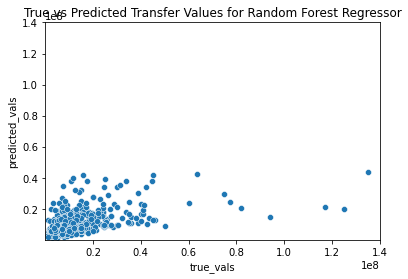

In [33]:
fig, ax = plt.subplots()
sns.scatterplot(x='true_vals', y='predicted_vals',
             data = plotting_data, ax=ax).set_title('True vs Predicted Transfer Values for Random Forest Regressor')

ax.set_xlim(1,1.4e8)
ax.set_ylim(1,1.4e8)
plt.show()
None

As we can see the data does seem to generally follow the line of x=y, which is what we were hoping for. It should be noted that our regression is definitely skewed towards predicting lower transfer fees than what happens in reality, as a number of true values are over 0.4e8 (40 million), while our model only predicts 3 transfers to be over 40 million. I'll do another plot that doesn't include some of the outliers to get a better picture of what is happening with the majority of the data.

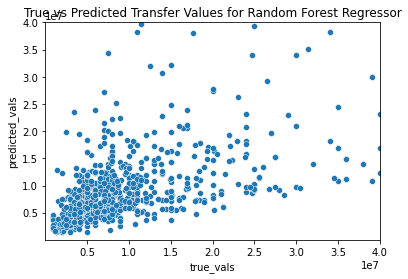

In [34]:
fig, ax = plt.subplots()
sns.scatterplot(x='true_vals', y='predicted_vals',
             data = plotting_data, ax=ax).set_title('True vs Predicted Transfer Values for Random Forest Regressor')

ax.set_xlim(1,0.4e8)
ax.set_ylim(1,0.4e8)
plt.show()
None

This graph confirms our previous suspicions. The model performs really well in predicting transfers with very low transfer fees, but the predictions begin to vary more as the true value of the transfer increases.

## Trying a Time Series Split


In all of our previous ML models, we used a standard Train_Test_Split method to create training and testing datasets. This however, may not be the best method for this dataset, because it could be argued that these transfers are a time series of approximately twenty seasons. Thus, I will use the two best models from the previous sections (Random Forest Classifier and Random Forest Regressor) and train them using a TimeSeriesSplit.

In [35]:
unique_seasons = bucketed_df['Season'].nunique()
bucketed_df.sort_values('Season')
Y, X = pts.dmatrices('bucket ~ C(Position) + Age + C(Team_from) + C(League_from) + C(Team_to) + C(League_to) + Season',
                    data = bucketed_df,
                    return_type='dataframe')
np_Y = Y['bucket'].to_numpy()
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X),columns = X.columns)

In [36]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=unique_seasons - 1)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = np_Y[train_index], np_Y[test_index]
    model = RandomForestClassifier(bootstrap=rf_best_params['bootstrap'],
                                    max_depth=rf_best_params['max_depth'],
                                    max_features=rf_best_params['max_features'],
                                    n_estimators=rf_best_params['n_estimators'],
                                    n_jobs = -1).fit(X_train, y_train)
    yhat = model.predict(X_test)
    custom_classification_scoring(y_test, yhat)
    

Mean Relative Accuracy of this outer fold is: 
0.5404858299595142
Mean Relative Accuracy of this outer fold is: 
0.7364372469635628
Mean Relative Accuracy of this outer fold is: 
0.8230769230769233
Mean Relative Accuracy of this outer fold is: 
0.8004048582995951
Mean Relative Accuracy of this outer fold is: 
0.7805668016194333
Mean Relative Accuracy of this outer fold is: 
0.7417004048582998
Mean Relative Accuracy of this outer fold is: 
0.6951417004048582
Mean Relative Accuracy of this outer fold is: 
0.780161943319838
Mean Relative Accuracy of this outer fold is: 
0.7862348178137654
Mean Relative Accuracy of this outer fold is: 
0.7862348178137654
Mean Relative Accuracy of this outer fold is: 
0.7700404858299597
Mean Relative Accuracy of this outer fold is: 
0.7910931174089069
Mean Relative Accuracy of this outer fold is: 
0.7461538461538462
Mean Relative Accuracy of this outer fold is: 
0.8097165991902834
Mean Relative Accuracy of this outer fold is: 
0.748178137651822
Mean Relativ

As we can see in the later folds (in which the model is trained on most of the data and then tested on the later years), the TimeSeriesSplit is actually slightly better for Random Forest Classifier than the normal TrainTestSplit is. Now we will do the same thing, but with Random Forest Regression.

In [37]:
Y, X = pts.dmatrices('Transfer_fee ~ C(Position) + Age + C(Team_from) + C(League_from) + C(Team_to) + C(League_to) + Season',
                    data = class_df,
                    return_type='dataframe')

np_Y = Y['Transfer_fee'].to_numpy()
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X),columns = X.columns)

In [38]:
tscv = TimeSeriesSplit(n_splits=unique_seasons - 1)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = np_Y[train_index], np_Y[test_index]
    model = RandomForestRegressor(bootstrap=rrf_best_params['bootstrap'],
                                    max_depth=rrf_best_params['max_depth'],
                                    max_features=rrf_best_params['max_features'],
                                    n_estimators=rrf_best_params['n_estimators'],
                                    n_jobs = -1).fit(X_train, y_train)
    yhat = model.predict(X_test)
    reg_scorer(y_test, yhat)
    

Explained Variance of this outer fold is: 
0.002303374751599141
The R2 of this outer fold is: 
-27.95010132498475
Explained Variance of this outer fold is: 
0.18528941322524894
The R2 of this outer fold is: 
-14.509243947636268
Explained Variance of this outer fold is: 
0.2010732569758279
The R2 of this outer fold is: 
-5.519252981552944
Explained Variance of this outer fold is: 
-0.33987317620873836
The R2 of this outer fold is: 
-7.930682625460458
Explained Variance of this outer fold is: 
0.036479665783772375
The R2 of this outer fold is: 
-4.969549231916042
Explained Variance of this outer fold is: 
-0.015232290582614771
The R2 of this outer fold is: 
-6.257043392203258
Explained Variance of this outer fold is: 
-0.7337405209732721
The R2 of this outer fold is: 
-9.110099723870045
Explained Variance of this outer fold is: 
-0.16379971006056326
The R2 of this outer fold is: 
-4.369976751619813
Explained Variance of this outer fold is: 
0.06575375795029514
The R2 of this outer fold i

Interestingly enough, the Random Forest Regression performed significantly worse on the TimeSeriesSplit data in comparison to the TrainTestSplit data. I would stick with normal TrainTestSplit if I were to use regression going forward.

## Further Improvements / Next Steps

If I really wanted to make this model the best that it could possibly be, there are a number of further experiments that I could perform. I could perform some feature selection or PCA to see if a simpler input dataset can allow the model to achieve greater accuracy. I could also perform further hyperparameter optimization by both making the initial grid search larger and also including a second grid search to look over a range of hyperparameters surrounding the best ones from the original grid search. I would also compare a TimeSeriesSplit to TrainTestSplit for every single model rather than just the best ones with TrainTestSplit. Finally, I would also try to augment this dataset with more data from the last couple of seasons and just more data overall. The model could probably achieve a significant amount of improvement with all of these steps.